In [1]:
import argparse
import sys
sys.path.append('/disk/bifrost/yuanze/software/GalfitS/src')
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["GS_DATA_PATH"] = "/disk/bifrost/yuanze/software"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import gsutils
import pickle
from astropy.stats import sigma_clipped_stats
from astropy.visualization.mpl_normalize import simple_norm
from astropy.table import Table, Column
import matplotlib.pyplot as plt
import numpy as np
import time
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,z_at_value
from astropy.io import ascii

config_file_path = "/disk/bifrost/yuanze/KBSS/Q1549/BX101/GalfitS/BX101.lyric"
workplace = "/disk/bifrost/yuanze/KBSS/Q1549/BX101/GalfitS"
#readpar="/disk/bifrost/yuanze/KBSS/Q1549/BX101/GalfitS/link2.params"
parser = argparse.ArgumentParser(description="Run galfitS")
parser.add_argument("--config", type=str, default=config_file_path, help="config file of galfitS")
parser.add_argument("--workplace", type=str, default=workplace, help="filepath to store galfitS outputs")
parser.add_argument("--notfit", action='store_true', help="not fit, only generate parameter file")
parser.add_argument("--fit_method", type=str, default="optimizer", help="chisq, flowmc, dynesty, optimizer, ES")
parser.add_argument("--num_steps", type=int, default=6000, help="num_steps for optimizer fitting")
parser.add_argument("--learning_rate", type=float, default=0.001, help="learning_rate for optimizer fitting")
parser.add_argument("--cal_sigma", action='store_true', help="calculate hessian_sigma for optimizer fitting")
parser.add_argument("--chimethod", type=str, default="scipy", help="method for chisq fitting")
parser.add_argument("--scimethod", type=str, default="SLSQP", help="method for scipy fitting")
parser.add_argument("--constrain", action='store_true', help="constrain for chisq fitting")
parser.add_argument("--nchains", type=int, default=30, help="nchains for flowmc")
parser.add_argument("--rstep", type=float, default=0.1, help="parameter step for flowmc")
parser.add_argument("--nlocalsteps", type=int, default=3000, help="nlocalsteps for flowmc")
parser.add_argument("--nlooptraining", type=int, default=20, help="nlooptraining for flowmc")
parser.add_argument("--nloopproduction", type=int, default=10, help="nloopproduction for flowmc")
parser.add_argument("--sampler", type=str, default="GRW", help="sampler for flowmc")
parser.add_argument("--nlive", type=int, default=80, help="numbe of live point for dynesty")
parser.add_argument("--maxiters", type=int, default=100000, help="maxiters for dynesty")
parser.add_argument("--dlogz", type=float, default=0.02, help="dlogz for dynesty")
parser.add_argument("--sample_method", type=str, default="rwalk", help="sample_method for dynesty")
parser.add_argument("--dynamic", action='store_true', help="dynamic for dynesty")
parser.add_argument("--maxbatch", type=int, default=10, help="maxbatch for dynesty")
parser.add_argument("--parconstrain", type=str, default="default", help="filepath to store parameter constrain")
parser.add_argument("--readpar", type=str, default="default", help="filepath to read parameter")
parser.add_argument("--readsummary", type=str, default="default", help="filepath to read summary file")
parser.add_argument("--savefull_results", action='store_true', help="save full results or not")
parser.add_argument("--weight_spec", type=float, default=1.0, help="weight of spectrum in fitting")
parser.add_argument("--num_generations", type=int, default=10000, help="num_generations for ES")
parser.add_argument("--popsize", type=int, default=20, help="popsize for ES")
parser.add_argument("--fixagnlinepro", action='store_true', help="fix agn line profile or not")
parser.add_argument("--ndisagn", action='store_true', help="display agn or not in the image")
args = parser.parse_known_args()[0]


if not os.path.exists(config_file_path):
        raise ValueError("config file path not found!")
if not os.path.exists(workplace):
        os.mkdir(workplace)
        print ("workplace path not found! create it!")
Myfitter,targ,fs = gsutils.read_config_file(config_file_path,workplace,fixagnlinepro = args.fixagnlinepro)
if args.parconstrain != "default":
        f = open(args.parconstrain,'r')
        fs = f.read()
exec(fs)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO: using the unit cR passed to the FITS reader instead of the unit MJy/sr in the FITS file. [astropy.nddata.ccddata]
conversion factor is  7.98274194e+18
INFO: using the unit cR passed to the FITS reader instead of the unit MJy/sr in the FITS file. [astropy.nddata.ccddata]
conversion factor is  2.52294066e+19
INFO: using the unit cR passed to the FITS reader instead of the unit ELECTRONS/S in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


conversion factor is  1.28230335e+19
INFO: using the unit cR passed to the FITS reader instead of the unit 10^(-8)erg/s/cm3/arcsec2 in the FITS file. [astropy.nddata.ccddata]


Set MJD-BEG to 58987.348419 from DATE-BEG.
Set MJD-END to 58987.362308 from DATE-END'. [astropy.wcs.wcs]


conversion factor is  1.11111111e+17


In [2]:

if args.readpar != "default":
        ptab = Table.read(args.readpar, format='ascii')
        pkeys = Myfitter.pardict.keys()
        for loop in range(len(pkeys)):
                el = ptab['name'][loop]
                if ptab['vary'][loop] == 'False':
                        var = False
                else:
                        var = True
                if ptab['expr'][loop] == 'None':
                        Myfitter.lmParameters[el].set(value=ptab['value'][loop],vary=var,min=ptab['min'][loop],max=ptab['max'][loop],brute_step=ptab['brute_step'][loop])
                else:
                        Myfitter.lmParameters[el].set(value=ptab['value'][loop],vary=var,expr=ptab['expr'][loop],min=ptab['min'][loop],max=ptab['max'][loop],brute_step=ptab['brute_step'][loop])
        Myfitter.loose_fix_pars()
        f = open(workplace + '/{0}.params'.format(targ), 'w')
        print ('name value min max brute_step vary expr', file=f)
        for el in Myfitter.pardict:
                print('{0} {1} {2} {3} {4} {5} {6}'.format(el,Myfitter.pardict[el],Myfitter.lmParameters[el].min,Myfitter.lmParameters[el].max,Myfitter.lmParameters[el].brute_step,Myfitter.lmParameters[el].vary,Myfitter.lmParameters[el].expr), file=f)
        f.close()
        # update constraints
        fs = gsutils.generate_cons_func(Myfitter.lmParameters)
        exec(fs)
        f = open(workplace + '/{0}.constrain'.format(targ), 'w')
        print(fs, file=f)
        f.close()

if args.readsummary != "default":
        sumfile = ascii.read(args.readsummary)
        for loop in range(len(sumfile)):
                try:
                        Myfitter.lmParameters[sumfile['pname'][loop]].set(value = sumfile['best_value'][loop])
                except KeyError:
                        print ("{0} not in parameter list, skip it!".format(sumfile['pname'][loop]))
        Myfitter.loose_fix_pars()
if not args.notfit:
        # timeing
        start = time.time()
        Myfitter.Set_Update_Constraints(Update_Constraints)
        Myfitter.set_wight_spec(args.weight_spec)
        if args.fit_method == "chisq":
                fr = Myfitter.minimize(method=args.chimethod,scipymethod=args.scimethod,constrain = args.constrain)
        elif args.fit_method == "flowmc":
                fr = Myfitter.flowmc(n_chains = args.nchains, r_step = args.rstep, n_local_steps = args.nlocalsteps, n_loop_training = args.nlooptraining, n_loop_production = args.nloopproduction, sampler = args.sampler)
        elif args.fit_method == "dynesty":
                fr = Myfitter.nested_sampling(maxiters=args.maxiters, nlive=args.nlive,dlogz = args.dlogz,sample_method=args.sample_method,dynamical=args.dynamic,dynesty_kwargs={'maxbatch': args.maxbatch , 'use_stop': False,})
        elif args.fit_method == "optimizer":
                fr = Myfitter.optimizer(num_steps=args.num_steps, learning_rate=args.learning_rate, calsigma=args.cal_sigma)
        elif args.fit_method == "ES":
                fr = Myfitter.evolution_strategies(num_generations=args.num_generations, popsize=args.popsize)
        else:
                raise ValueError("fit_method not supported!")
        stop = time.time()


        if args.savefull_results:
                if args.fit_method == "chisq":
                        result = {
                        'resultDit': fr,
                        'pardict': Myfitter.pardict,
                        'varnames': Myfitter.varnames,
                        }
                else:
                        result = {
                        'resultDit': dict(fr),
                        'pardict': Myfitter.pardict,
                        'varnames': Myfitter.varnames,
                        }
                pickle.dump(result,open(workplace + '/{0}.gsresu'.format(targ),"wb"))

        # write summary file
        f = open(workplace + '/{0}.gssummary'.format(targ),'w')
        f.write('# target: {0}\n'.format(targ))
        f.write('# config file: {0}\n'.format(config_file_path))
        f.write('# fitting mode: {0}\n'.format(Myfitter.GSdata.fitMode))
        if Myfitter.GSdata.fitMode == "single image - photometry":
                f.write('### Magnitude can be found in fixed parameters.\n')
                f.write('### Magnitude error can be calculated by 2.5 times the logM error.\n')
        f.write('# fiting method: {0}\n'.format(args.fit_method))
        f.write('# chisq: {0}\n'.format(Myfitter.chisq))
        f.write('# reduced chisq: {0}\n'.format(Myfitter.chisq/Myfitter.dof))
        f.write('# fitting time: {0} mins\n'.format((stop-start)/60.))
        f.write('######################################### \n')
        if args.fit_method == "chisq":
                f.write('# method: {0}  scipymethod: {1} \n'.format(args.chimethod,args.scimethod))
                f.write('# free parameters:\n')
                f.write('pname    best_value\n')
                ncol = 2
                for loop, var in enumerate(Myfitter.varnames):
                        f.write('{0}    {1:.4f}\n'.format(var,Myfitter.theta0[loop]))
        elif args.fit_method == "ES":
                f.write('# num_generations: {0}  popsize: {1} \n'.format(args.num_generations,args.popsize))
                f.write('# free parameters:\n')
                f.write('pname    best_value \n')
                ncol = 2
                for loop, var in enumerate(Myfitter.varnames):
                        f.write('{0}    {1:.4f}\n'.format(var,fr['theta'][loop]))
        elif args.fit_method == "optimizer":
                f.write('# num_steps: {0}  learning_rate: {1} calculate_hessian: {2} \n'.format(args.num_steps,args.learning_rate,args.cal_sigma))
                f.write('# free parameters:\n')
                if args.cal_sigma:
                        f.write('pname    best_value    best_value_uncertainty\n')
                        ncol = 3
                        for loop, var in enumerate(Myfitter.varnames):
                                f.write('{0}    {1:.4f}    {2:.4f}\n'.format(var,fr['theta'][loop],fr['param_errors'][loop]))
                else:
                        f.write('pname    best_value\n')
                        ncol = 2
                        for loop, var in enumerate(Myfitter.varnames):
                                f.write('{0}    {1:.4f}\n'.format(var,fr['theta'][loop]))       
        elif args.fit_method == "flowmc":
                f.write('# nchains: {0} parastep: {1} nlocalsteps: {2} nlooptraining: {3} nloopproduction: {4} sampler: {5}\n'.format(args.nchains,args.rstep,args.nlocalsteps,args.nlooptraining,args.nloopproduction,args.sampler))
                f.write('# free parameters:\n')
                f.write('pname    50%_value    16%_value     84%_value\n')
                ncol = 4
                for loop, var in enumerate(Myfitter.varnames):
                        f.write('{0}    {1:.4f}    {2:.4f}    {3:.4f}\n'.format(var,fr['quantiles'][0][loop],fr['quantiles'][1][loop],fr['quantiles'][2][loop]))
        elif args.fit_method == "dynesty":
                f.write('# maxiters: {0} nlive: {1} dlogz: {2} sample_method: {3} dynamic: {4} maxbatch: {5}\n'.format(args.maxiters,args.nlive,args.dlogz,args.sample_method,args.dynamic,args.maxbatch))
                f.write('# free parameters:\n')
                f.write('pname    best_value    uncertainty\n')
                ncol = 3
                for loop, var in enumerate(Myfitter.varnames):
                        f.write('{0}    {1:.4f}    {2:.4f}\n'.format(var,fr['best_theta'][loop],fr['uncertainty'][loop]))
        f.write('# fixed parameters:\n')
        f.write('# pname    fixed_value\n')
        for el in Myfitter.pardict.keys():
                if not Myfitter.lmParameters[el].vary:
                        if ncol == 2:  
                                f.write('{0}    {1:.4f}\n'.format(el,Myfitter.pardict[el]))
                        elif ncol == 3:
                                f.write('{0}    {1:.4f}    {2}\n'.format(el,Myfitter.pardict[el],0.))
                        elif ncol == 4:
                                f.write('{0}    {1:.4f}    {2}    {3}\n'.format(el,Myfitter.pardict[el],0.,0.))
        f.write('######################################### \n')
        f.close()



2023-10-04 17:34:49.483806: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-10-04 17:37:28.437679: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m38.954124326s

********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Step 0, Chisq: 1710741.0
Step 100, Chisq: 1400493.125
Step 200, Chisq: 1276277.625
Step 300, Chisq: 1190608.375
Step 400, Chisq: 1116432.375
Step 500, Chisq: 1033074.25
Step 600, Chisq: 888601.8125
Step 700, Chisq: 494117.15625
Step 800, Chisq: 250851.171875
Step 900, Chisq: 234653.875
Step 1000, Chisq: 222460.078125
Step 1100, Chisq: 212618.109375
Step 1200, Chisq: 204273.296875
Step 1300, Chisq: 196941.4375
Step 1400, Chisq: 190320.515625
Step 1500, Chisq: 184316.921875
Step 1600, Chisq: 178844.015625
Step 1700, Chisq: 173907.8125
Step 1800, Chisq: 169500.8125
Step 1900, Chisq: 165618.53125
Step 2000, Chisq: 162206.609375
Step 2100, Chisq: 159172.46875
Step 2200, Chisq: 156423.921875
Step 2300, Chisq: 153898.765625
Step 2400, Chisq: 151552.0625
Step 2500, Chisq: 149378.8125
Step 2600, Chisq: 147388.8125
Step 2700, Chisq: 145571.46875
Step 2800, Chisq: 143942.453125
Step 2900, Chisq: 142492.59375
Step 3000, Chisq: 141210.6875
Step 3100, Chisq: 140080.984375
Step 3200, Chisq: 139078.07

In [3]:
gsutils.standard_display(Myfitter, workplace, targ, ndisage = args.ndisagn)

In [5]:
#pltwave, Sedcomp, Sedlabel, z = Myfitter.cal_model_image(ndisag                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      n=False)
galaxy = Myfitter.model_list[1]
AGN = Myfitter.model_list[0]

im = Myfitter.GSdata.get_image(2)
print(im.band)
image_atlas = Myfitter.GSdata.image_atlas_list[2]
print(image_atlas.name)

#tidalimg = galaxy.generate_subcomponent_image(im.band,im.PSF,'tidal')*im.phys_to_counts_rate
ny,nx=im.cut_image.shape
Gimage,apertures = galaxy.generate_mass_map((ny,nx),transpar=im.coordinates_transfer_para)
diskimg = galaxy.generate_subcomponent_image(im.band,im.PSF,'disk',nebularpar = Myfitter.pardict)*im.phys_to_counts_rate
gimage = galaxy.generate_image(im.band,im.PSF,noSED=False,nebularpar = Myfitter.pardict)*im.phys_to_counts_rate
nuim = AGN.generate_image([Myfitter.pardict['agn_xnu'],Myfitter.pardict['agn_ynu']],(ny,nx),im.band,im.PSF,transpar=im.coordinates_transfer_para,pardict=Myfitter.pardict)
nuim *= Myfitter.pardict['Ni_{0}_{1}'.format(AGN.prefix,image_atlas.name)]
nuim *= im.phys_to_counts_rate

KCWI_squashed
BX_HST


Text(3, 3, 'Full model')

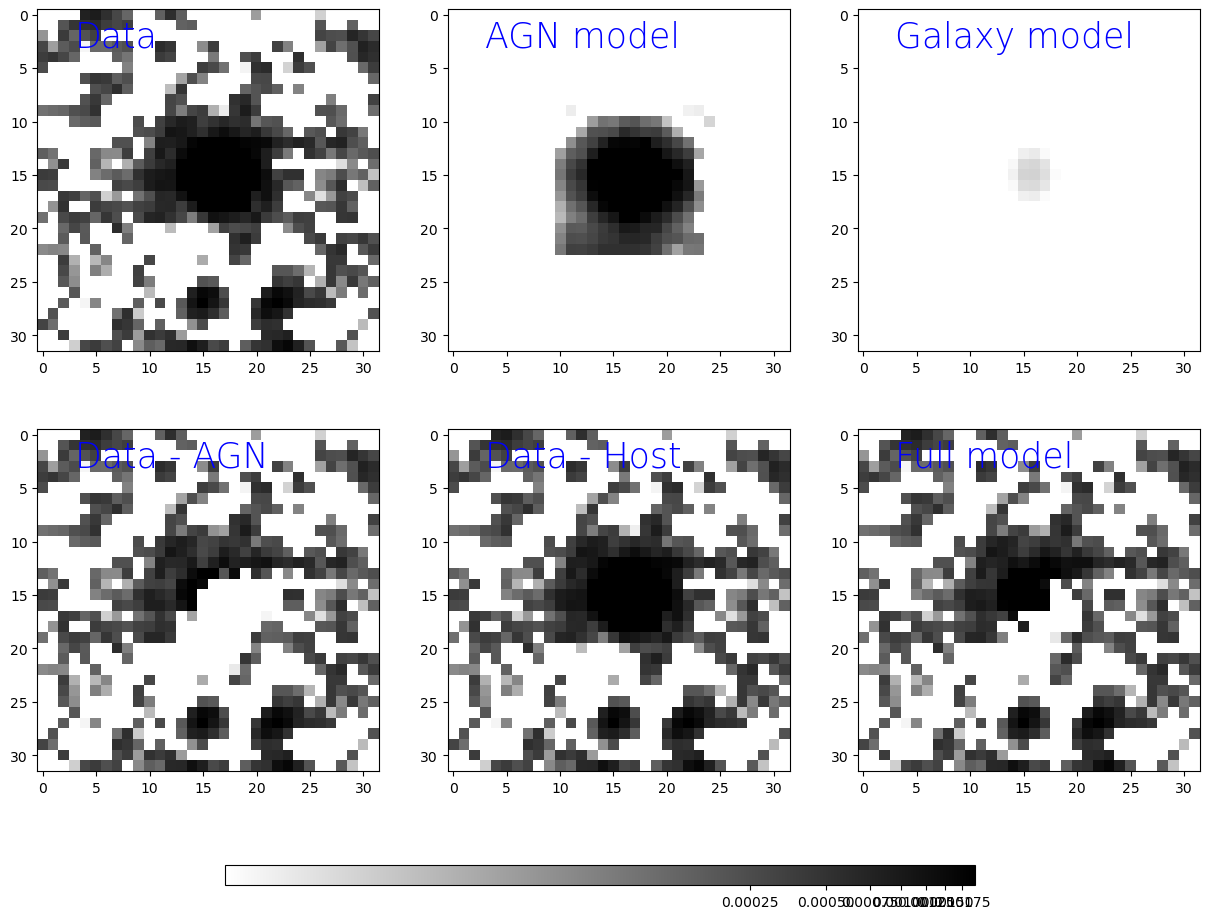

In [11]:
import jax.numpy as jnp
from matplotlib.colors import LogNorm
from matplotlib.colorbar import ColorbarBase
sky_mean, sky_median, sky_std = sigma_clipped_stats(im.cut_image, sigma=3.0, maxiters=5)
immin = 1e-2*sky_std
immax = jnp.max(im.cut_image)
frac = 0.8
norm = simple_norm([0.01*sky_std, 5*sky_std], 'log', percent=100)
#norm= LogNorm()
cmap='gray_r'
interpolation='nearest'
fig,axs=plt.subplots(2,3,figsize=(15, 10),squeeze=True)
axs=axs.ravel()
axs[0].imshow(im.cut_image-sky_median,cmap=cmap,interpolation=interpolation, norm=norm)
axs[1].imshow(nuim,cmap=cmap,interpolation=interpolation, norm=norm)
axs[2].imshow(gimage, cmap=cmap,interpolation=interpolation, norm=norm)
axs[3].imshow(im.cut_image-nuim-sky_median, cmap=cmap,interpolation=interpolation, norm=norm)
axs4=axs[4].imshow(im.cut_image-diskimg-sky_median, cmap=cmap,interpolation=interpolation, norm=norm)
axs[5].imshow(im.cut_image-im.model_image-sky_median, cmap=cmap,interpolation=interpolation, norm=norm)
cbax = fig.add_axes([0.25,0.0,0.5,0.02])
cbar = ColorbarBase(cbax, cmap=cmap,norm=norm,orientation='horizontal')
axs[0].text(3,3, "Data", size = 25, color = 'b', weight = "light" )
axs[1].text(3,3, "AGN model", size = 25, color = 'b', weight = "light" )
axs[2].text(3,3, "Galaxy model", size = 25, color = 'b', weight = "light" )
axs[3].text(3,3, "Data - AGN", size = 25, color = 'b', weight = "light" )
axs[4].text(3,3, "Data - Host", size = 25, color = 'b', weight = "light" )
axs[5].text(3,3, "Full model", size = 25, color = 'b', weight = "light" )

# SED plotting

In [12]:
wavegrid = jnp.linspace(1e3,8e4,1000)
sed=AGN.fiducial_sed(wavegrid,pardict=Myfitter.pardict)
flist, namelist = galaxy.get_component_SED(wavegrid, nebularpar = Myfitter.pardict)

sky = Myfitter.pardict['sky_{0}'.format(im.band)]
fluxphot = jnp.sum(jnp.where(im.cut_mask_image, 0., im.cut_image))/im.phys_to_counts_rate
wavephot = 4.5e4
emap = jnp.where(im.cut_mask_image, 0., im.cut_sigma_image)
errorphot = jnp.sqrt(jnp.sum(emap**2))/im.phys_to_counts_rate

surb=8.461595e-29*jnp.sum(jnp.where(im.cut_mask_image, 0., im.cut_image-sky))
MAB=-2.5*np.log10(surb)-48.6
print(surb)
print(MAB)

1.7392056e-28
20.799127960205077


Text(0, 0.5, 'L$_{38}$')

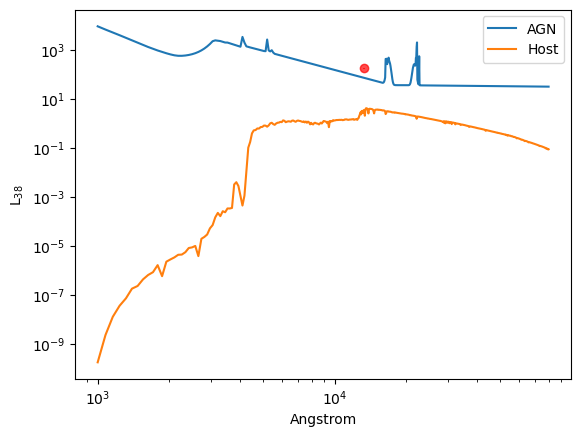

In [18]:
plt.plot(wavegrid,sed,label='AGN')
plt.plot(wavegrid,flist[0]+flist[1]+flist[2],label='Host')
#plt.plot(wavegrid,sed+flist[0])
#plt.plot(wavegrid,flist[1],label='ISM')
plt.errorbar(wavephot/(1+AGN.redshift), fluxphot,yerr=errorphot, fmt='o',color='r',alpha=0.7)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Angstrom")
plt.ylabel(r"L$_{38}$")

In [16]:
namelist

['mygaldisk_star', 'mygaldisk_ISM', 'mygalnebulines']

# IFS data generation with known AGN model and ePSF

In [4]:
#Read the coordinate transfer parameters of the IFS data
from astropy.io import fits
#from spectral_cube import SpectralCube
import images as IM
from spectral_cube import SpectralCube
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import jax.numpy as jnp
z=2.3806
cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.308)
d=cosmo.luminosity_distance(z)
dc=d.to(u.cm)
dis=dc.value
C_unit=1e38/(4*np.pi*dis**2)

S=np.pi*(1.8*u.arcsec)**2*1e-8

Spix=(0.3*u.arcsec)**2


factor=Spix/(u.AA/u.cm*u.cm.to(u.AA))*1e8

#factor: SB to flambda
KCWIpath='/disk/bifrost/yuanze/KBSS/Q1549/BX101/kcwi_oned'
ecube='q1549-BX101_ecubes.fits'
icube='q1549-BX101_icubes_wcs.fits'
psfimg=jnp.array(fits.open(KCWIpath+'/KCWI_CIV_psf.fits')[0].data)
fname=KCWIpath+'/'+icube
redshift=2.3806
img = IM.image(fname,IFS=True)
inicube = SpectralCube.read(KCWIpath+'/'+icube) 
iniecube = SpectralCube.read(KCWIpath+'/'+ecube)
iniwcs=inicube.wcs.celestial
img.phys_to_counts_rate=1e17*C_unit


In [46]:
#print(img.phys_to_counts_rate.value
#print(np.sum(extpsf[:,:,500]))
import profiles as Pro
transformed_psfimage = Pro.add_PSF_3D(15, 15, 32, 32, extpsf, 1.)

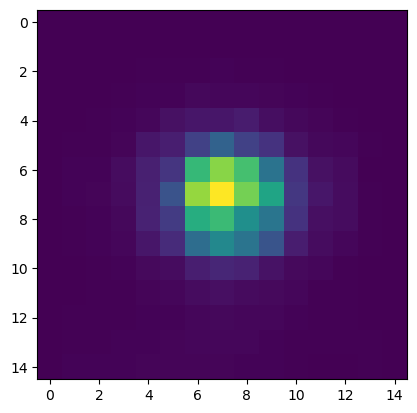

In [60]:
plt.imshow(extpsf[:,:,500])

In [8]:
import galaxy as GA
xpix,ypix = GA.coordinates_transfer(0,-0.3,img.coordinates_transfer_para)
print(xpix,ypix)

16.6 15.327999971803573


In [9]:
cutr=float(5)
ra, dec = 237.98053,19.15891
imcut, cp = img.img_cut(ra,dec,cutr)

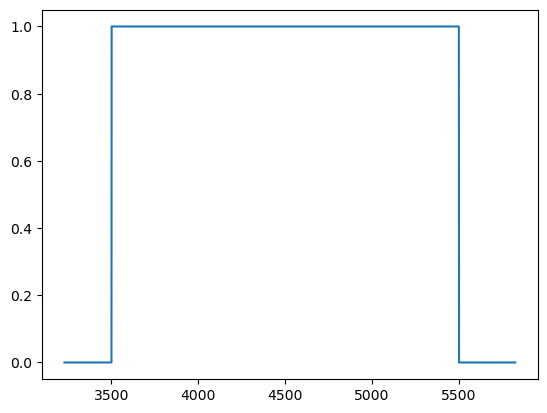

In [10]:
wavelength=inicube.spectral_axis.value
throughput=np.ones(len(wavelength))
throughput[(wavelength<3500) | (wavelength > 5500)]=0
plt.plot(wavelength,throughput)

In [89]:
extpsf=psfimg[:,:,None]*throughput[None,None,:]

IFU=AGN.generate_IFU(wavelength,[0.1,-0.4],imcut.shape[1:],extpsf
                 ,LSF_FWHM=1.6, GaussianLSF=True ,pardict=Myfitter.pardict,transpar=img.coordinates_transfer_para)

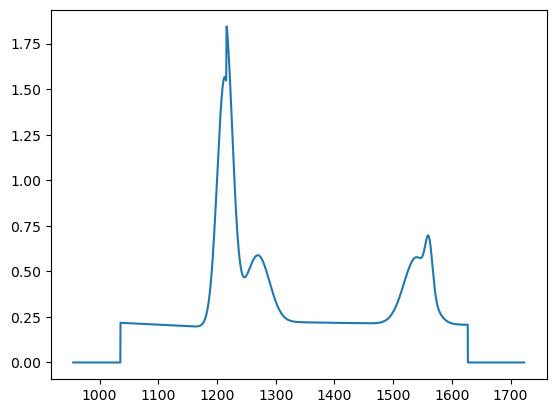

In [53]:
pix_to_arcsec=(0.3*u.arcsec)**2
#0.3 arcsec^2/pixel
#IFU: Flambda/pixel^2
plt.plot(wavelength/(1+AGN.redshift),IFU[:,15,15])


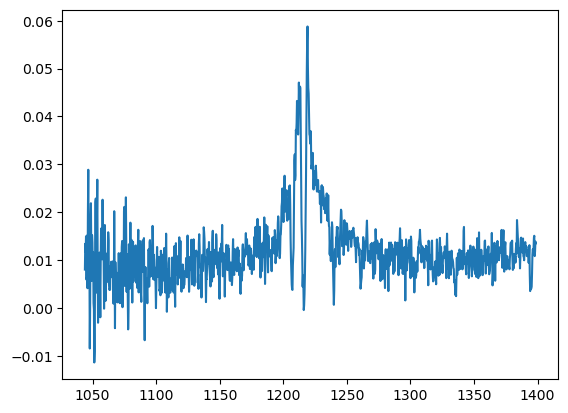

In [44]:
plt.plot(wavelength[300:1500]/(1+AGN.redshift),imcut[300:1500,15,15])

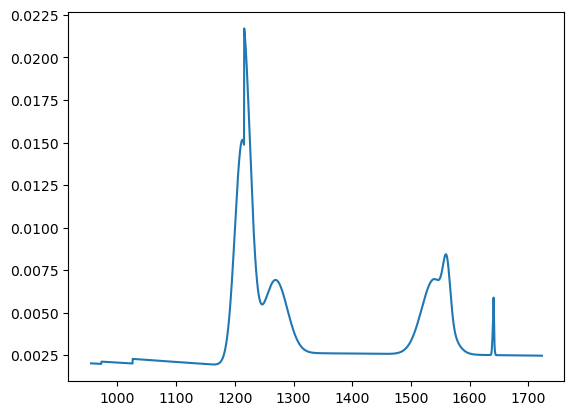

In [54]:
#print(transformed_psfimage[1230,15,15])
#print(fiducial_sed[1230])
pltwave, Sedcomp, Sedlabel, z = Myfitter.cal_model_image()
waverest = wavelength/(1.+redshift)
agnsed_rest = AGN.fiducial_sed(wavelength,Myfitter.pardict)

another_sed,sedcomp = AGN.get_component_SED(image_atlas.spectra[2][0],pardict=Myfitter.pardict)
import sed_interp as SEDs
cm=SEDs.jccm89(waverest,AGN.Av,3.1)/2.5
agnsed_rest /= 10**cm
_,agnsed_obs = SEDs.sed_to_obse(waverest,agnsed_rest,AGN.redshift,AGN.ebv_G)
plt.plot(waverest,agnsed_obs*C_unit/9e-18)


In [178]:
sedcomp

['Disk', 'Broad lines', 'Narrow lines', 'Torus']

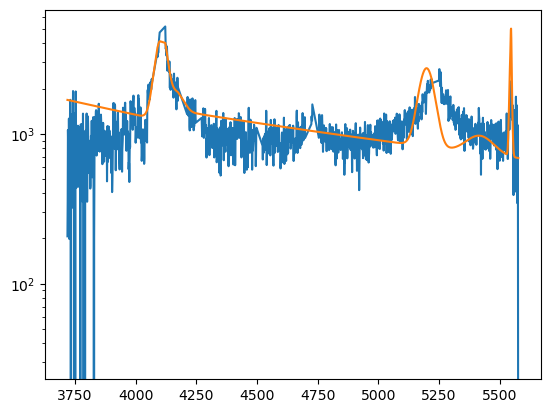

In [16]:
plt.plot(image_atlas.spectra[2][0],image_atlas.spectra[2][1])
plt.plot(image_atlas.spectra[2][0],image_atlas.modelspec[2])
#plt.plot(image_atlas.spectra[2][0],Sedcomp[2][0]*transformed_psfimage[500,15,15])
#plt.plot(image_atlas.spectra[2][0],another_sed[0])
#plt.plot(agnsed_rest
plt.yscale('log')
#print(transformed_psfimage[500,15,15])

In [55]:
1/9e-18

1.1111111111111112e+17

In [90]:
Lyaslicemo=np.mean(IFU[(wavelength>(1+AGN.redshift)*1545) & (wavelength<(1+AGN.redshift)*1555),:,:],axis=0)*C_unit/9e-18
Lyaslicedata=np.mean(imcut[(wavelength>(1+AGN.redshift)*1545) & (wavelength<(1+AGN.redshift)*1555),:,:],axis=0)
#transpsfslice=np.mean(transformed_psfimage[(wavelength>(1+redshift)*1210) & (wavelength<(1+redshift)*1225),:,:],axis=0)
sky_mean, sky_median, sky_std = sigma_clipped_stats(Lyaslicedata, sigma=3.0, maxiters=5)

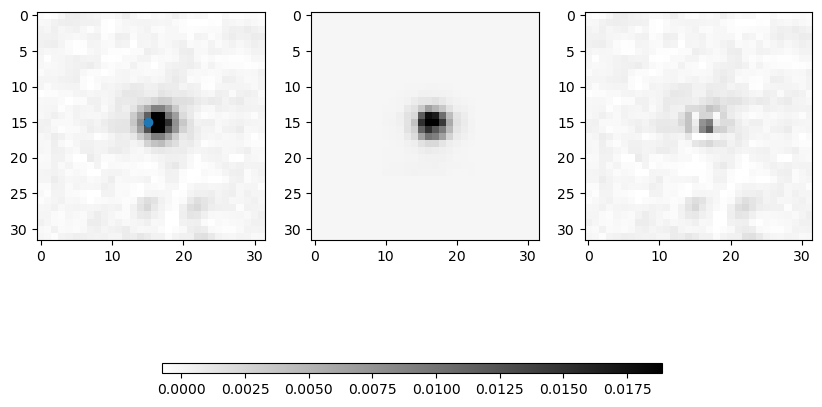

In [92]:
from matplotlib.colors import LogNorm
from matplotlib.colorbar import ColorbarBase
fig,axs=plt.subplots(1,3,figsize=(10,5))
cmap='gray_r'
norm = simple_norm(Lyaslicedata, 'linear', percent=99.)
axs[0].imshow(Lyaslicedata-sky_median,cmap=cmap,norm=norm)
axs[0].scatter(15,15)
axs[1].imshow(Lyaslicemo,cmap=cmap,norm=norm)
axs[2].imshow(Lyaslicedata-Lyaslicemo-sky_median,cmap=cmap,norm=norm)
#axs[1].imshow(extpsf[:,:,300],cmap=cmap,norm=norm)
cbax = fig.add_axes([0.25,0.0,0.5,0.02])
cbar = ColorbarBase(cbax, cmap=cmap,norm=norm,orientation='horizontal')